In [1]:
import pyroomacoustics as pra

import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

from src.dataset import SignalDataset, TRUNetDataset
from src.loss import loss_tot
from models.model1d_stream_med_1dphm import TRUNet 

import matplotlib.pyplot as plt

In [2]:
DATA_DIR = os.path.join("..", "data", "data_thchs30")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
NOISE_DIR = os.path.join("..", "data", "test-noise", "noise", "white")

In [3]:
N_FFTS = 512
HOP_LENGTH = 256

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
train_dataset = TRUNetDataset(TRAIN_DIR, noise_dir=NOISE_DIR, snr=(-5, 25))
test_dataset = TRUNetDataset(TEST_DIR, noise_dir=NOISE_DIR, snr=(-5, 25))

In [5]:
sig, gt = train_dataset[0]

In [6]:
def vorbis_window(winlen, device="cuda"):
    sq = torch.sin(torch.pi/2*(torch.sin(torch.pi/winlen*(torch.arange(winlen)-0.5))**2)).float()
    return sq

In [7]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)

    input_signal, target_signal = zip(*batch)
        
    max_len = max(s.shape[-1] for s in input_signal)
    
    padded_input = torch.zeros(len(input_signal), max_len)
    padded_target = torch.zeros(len(target_signal), max_len)
    for i, s in enumerate(input_signal):
        padded_input[i, :s.shape[-1]] = s
        padded_target[i, :s.shape[-1]] = target_signal[i]

    return padded_input, padded_target

def collate_fn(batch):
    
    padded_input, padded_target = pad_sequence(batch)
    
    batch_size, t = padded_input.shape
    
    padded_input = padded_input.unfold(-1, 16_000 * 2, 16_000)
    padded_target = padded_target.unfold(-1, 16_000 * 2, 16_000)
    
    window = vorbis_window(512, device=DEVICE)
    
    input_spec = []
    for s in padded_input:
        input_spec.append(torch.stft(
            s,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=512,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ))
        
    input_spec = torch.stack(input_spec)
        
    return input_spec, padded_target

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=4)

In [16]:
fgru_hidden_size = 64
tgru_hidden_size = 128

count = 10


def train(model, train_loader, optimizer, device="cuda"):
    total_train_loss = 0
    
    ind = 0
    
    for input_spec, gt_signal in train_loader:
        optimizer.zero_grad()
        h_f = torch.randn(2, input_spec.shape[0] * input_spec.shape[-1], fgru_hidden_size, device=device)
        h_t = torch.randn(1, 16, tgru_hidden_size, device=device)
        loss = 0
        # Слить batch_size и frames_num в одну размерность
        for ind in range(input_spec.shape[1]):
            input_frame = input_spec[:, ind, ...].to(device)
            gt_frame = gt_signal[:, ind, ...].to(device)
            
            output, h_f, h_t = model(input_frame.abs(), input_frame.real, input_frame.imag, h_f, h_t)

            # output_direct = torch.polar(output_abs, input_frame.angle())

            window = vorbis_window(512).to(device)
            out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
                                   window=window,
                                   return_complex=False,
                                   normalized=True,
                                   center=True, )
            # print(out_wave.shape, gt_signal.shape)
            loss += loss_tot(out_wave, gt_frame)
            
        loss.backward()
        optimizer.step()
        total_train_loss += loss.detach().item()
        ind += 1
        if ind >= count:
            break
    
    return model, optimizer, total_train_loss / len(train_loader)
            
def evaluate(model, test_loader, device="cuda"):
    total_test_loss = 0
    
    with torch.no_grad():
        ind = 0
        for input_spec, gt_signal in test_loader:
            h_f = torch.randn(2, input_spec.shape[0] * input_spec.shape[-1], fgru_hidden_size, device=device)
            h_t = torch.randn(1, 16, tgru_hidden_size, device=device)
            loss = 0
            for ind in range(input_spec.shape[1]):
                input_frame = input_spec[:, ind, ...].to(device)
                gt_frame = gt_signal[:, ind, ...].to(device)
                
                output, h_f, h_t = model(input_frame.abs(), input_frame.real, input_frame.imag, h_f, h_t)
                # print(type(output_abs), type(input_frame.angle()))
                # output_direct = torch.polar(output_abs, input_frame.angle())
                window = vorbis_window(512).to(device)
                out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=512,
                                       window=window,
                                       return_complex=False,
                                       normalized=True,
                                       center=True)
                
                loss += loss_tot(out_wave, gt_frame)
            
            total_test_loss += loss.detach().item()
            ind += 1
            if ind >= count:
                break
        
    return total_test_loss / len(test_loader)
    

def learning_loop(model, train_loader, val_loader, optimizer, epoch=10, device='cuda'):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epoch)):
        
        model.train()
        
        model, optimizer, total_train_loss = train(model, train_loader, optimizer)
        
        train_losses.append(total_train_loss)
        
        model.eval()
        val_loss = evaluate(model, val_loader)
        
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch}, Training Loss: {total_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    return model, train_losses, val_losses


In [17]:
from torch.optim import Adam

trunet = TRUNet()

optimizer = Adam(trunet.parameters(), lr=1e-4)

In [18]:
trunet, train_l, val_l = learning_loop(trunet, train_dataloader, test_dataloader, optimizer, device=DEVICE)

 10%|█         | 1/10 [00:16<02:26, 16.24s/it]

Epoch 0, Training Loss: 0.0069, Validation Loss: 0.0136


 20%|██        | 2/10 [00:45<03:12, 24.10s/it]

Epoch 1, Training Loss: 0.0103, Validation Loss: 0.0149


 30%|███       | 3/10 [01:01<02:20, 20.03s/it]

Epoch 2, Training Loss: 0.0107, Validation Loss: 0.0224


 40%|████      | 4/10 [01:22<02:03, 20.59s/it]

Epoch 3, Training Loss: 0.0136, Validation Loss: 0.0158


 50%|█████     | 5/10 [01:47<01:50, 22.01s/it]

Epoch 4, Training Loss: 0.0140, Validation Loss: 0.0227


 60%|██████    | 6/10 [02:06<01:24, 21.23s/it]

Epoch 5, Training Loss: 0.0076, Validation Loss: 0.0169


 70%|███████   | 7/10 [02:34<01:09, 23.33s/it]

Epoch 6, Training Loss: 0.0211, Validation Loss: 0.0120


 80%|████████  | 8/10 [03:07<00:53, 26.57s/it]

Epoch 7, Training Loss: 0.0141, Validation Loss: 0.0157


 90%|█████████ | 9/10 [03:32<00:26, 26.07s/it]

Epoch 8, Training Loss: 0.0036, Validation Loss: 0.0175


100%|██████████| 10/10 [03:58<00:00, 23.85s/it]

Epoch 9, Training Loss: 0.0047, Validation Loss: 0.0159


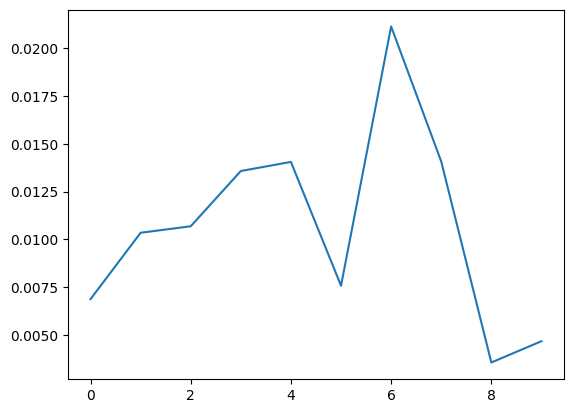

In [19]:
plt.plot(train_l, label='Train')

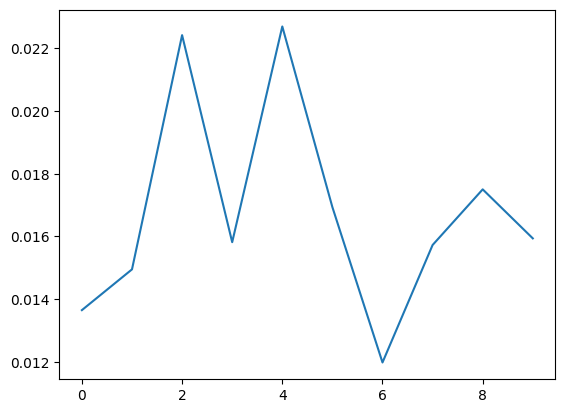

In [20]:
plt.plot(val_l, label='Validation')